# от Бондаренко Алексея (bondaleksey@gmail.com)

Цель данного ноутбука провести моделирование распространения болезни по аэропортам и посмотреть некоторые функции библиотеки работы с графами NetworkX


Основные пункты исследования: 

* реализация функции моделирование распространения болезни,
* оценка скорости распространения болезни,
* исследние графа распространения (при p = 0.5),
* заключение.

In [113]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

#technical 
%matplotlib inline
import warnings
import contextlib
import time

# 1. Данные

## 1.1 Описание признаков в наборе данных
Приведем [описание](https://docs.microsoft.com/en-us/machine-learning-server/r-reference/revoscaler/airlinedata87to08) набора [данных](https://www.kaggle.com/prajitdatta/data-stories-of-us-airlines) и 
**`выделим`** наиболее значимые признаки.

**Year** - year of the flight (stored as factor).

**Month** - month of the flight (stored as factor).

**`DayOfMonth`** - day of the month (1 to 31) (stored as integer).

**DayOfWeek** - day of the week (stored as factor).

**`DepTime`** - actual departure time (stored as float).

**`CRSDepTime`** - scheduled departure time (stored as float).

**`ArrTime`** - actual arrival time (stored as float).

**`CRSArrTime`** - scheduled arrival time (stored as float).

**UniqueCarrier** - carrier ID (stored as factor).

**FlightNum** - flight number (stored as factor).

**TailNum** - plane's tail number (stored as factor).

**`ActualElapsedTime`** - actual elapsed time of the flight, in minutes (stored as integer).

**CRSElapsedTime** - scheduled elapsed time of the flight, in minutes (stored as integer).

**AirTime** - airborne time for the flight, in minutes (stored as integer).

**ArrDelay** - arrival delay, in minutes (stored as integer).

**DepDelay** - departure delay, in minutes (stored as integer).

**`Origin`** - originating airport (stored as factor).

**`Dest`** - destination airport (stored as factor).

**Distance** - flight distance (stored as integer).

**TaxiIn** - taxi time from wheels down to arrival at the gate, in minutes (stored as integer).

**TaxiOut** - taxi time from departure from the gate to wheels up, in minutes (stored as integer).

**`Cancelled`** - cancellation status (stored as logical).

**CancellationCode** - cancellation code, if applicable (stored as factor).

**`Diverted`** - diversion status (stored as logical).

**CarrierDelay** - delay, in minutes, attributable to the carrier (stored integer).

**WeatherDelay** - delay, in minutes, attributable to weather factors (stored as integer).

**NASDelay** - delay, in minutes, attributable to the National Aviation System (stored as integer).

**SecurityDelay** - delay, in minutes, attributable to security factors (stored as integer).

**LateAircraftDelay** - delay, in minutes, attributable to late-arriving aircraft (stored as integer).

## 1.2. Чтение данных 

In [114]:
filename = "../data/airline_dec_2008_50k.csv"
df = pd.read_csv(filename, low_memory=False)
print(df.iloc[:3,:10])
print(df.iloc[:3,10:])

   Unnamed: 0  Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  \
0           1  2008     12           1          1      NaN        1000   
1           2  2008     12           1          1      NaN        1000   
2           3  2008     12           1          1      NaN        1000   

   ArrTime  CRSArrTime UniqueCarrier  
0      NaN        1100            WN  
1      NaN        1110            US  
2      NaN        1125            MQ  
   FlightNum TailNum  ActualElapsedTime  CRSElapsedTime  AirTime  ArrDelay  \
0         16  N366SW                NaN              60      NaN       NaN   
1       2122     NaN                NaN              70      NaN       NaN   
2       3155  N807MQ                NaN              85      NaN       NaN   

   DepDelay Origin Dest  Distance  TaxiIn  TaxiOut  Cancelled  \
0       NaN    HOU  DAL       239     NaN      NaN          1   
1       NaN    LGA  BOS       185     NaN      NaN          1   
2       NaN    SAN  SJC       417     N

In [115]:
print(df.shape)

(50000, 30)


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         50000 non-null  int64  
 1   Year               50000 non-null  int64  
 2   Month              50000 non-null  int64  
 3   DayofMonth         50000 non-null  int64  
 4   DayOfWeek          50000 non-null  int64  
 5   DepTime            32968 non-null  float64
 6   CRSDepTime         50000 non-null  int64  
 7   ArrTime            31418 non-null  float64
 8   CRSArrTime         50000 non-null  int64  
 9   UniqueCarrier      50000 non-null  object 
 10  FlightNum          50000 non-null  int64  
 11  TailNum            44556 non-null  object 
 12  ActualElapsedTime  31367 non-null  float64
 13  CRSElapsedTime     50000 non-null  int64  
 14  AirTime            31367 non-null  float64
 15  ArrDelay           31367 non-null  float64
 16  DepDelay           329

In [117]:
df.describe()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,50000.000000,50000.0,50000.0,50000.000000,50000.000000,32968.000000,50000.000000,31418.000000,50000.000000,50000.000000,...,50000.000000,31418.000000,32458.000000,50000.000000,50000.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000
mean,25000.500000,2008.0,12.0,11.350900,3.695000,752.043102,978.930920,791.598829,1076.869720,2592.855480,...,572.158120,7.166879,16.336866,0.355580,0.017080,12.044503,2.584316,18.813327,0.152273,7.957662
std,14433.901067,0.0,0.0,7.843122,1.889499,364.602722,496.930255,193.315743,495.563167,2116.729997,...,446.647873,5.539380,9.846548,0.478693,0.129571,31.444616,13.186963,21.499273,2.125548,29.794825
min,1.000000,2008.0,12.0,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,...,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12500.750000,2008.0,12.0,5.000000,2.000000,612.000000,630.000000,742.000000,805.000000,791.000000,...,261.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
50%,25000.500000,2008.0,12.0,10.000000,4.000000,657.000000,735.000000,831.000000,910.000000,2021.000000,...,446.000000,6.000000,14.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000
75%,37500.250000,2008.0,12.0,17.000000,5.000000,750.000000,1300.000000,914.000000,1315.000000,4114.000000,...,733.000000,9.000000,20.000000,1.000000,0.000000,14.000000,0.000000,25.000000,0.000000,0.000000
max,50000.000000,2008.0,12.0,31.000000,7.000000,2400.000000,2359.000000,2359.000000,2359.000000,7829.000000,...,3303.000000,156.000000,206.000000,1.000000,1.000000,1092.000000,209.000000,326.000000,96.000000,336.000000


## 1.3  DataFrame с рейсами фактических перелетов между аэропортами

Если рейс был отменен или если рейс перенаправлен, то информацию о таких перелетах извлечем из рассмотрения при моделировании.
Наиболее простой способ это выделить только те рейсы в которых **ActualElapsedTime** не `NaN`

In [118]:
flights = df[df['ActualElapsedTime'].notna()][["Origin","Dest", "DayofMonth", "CRSDepTime", "CRSArrTime","DepTime", "ArrTime","Cancelled","Diverted", "DepDelay","ActualElapsedTime"]]
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,Cancelled,Diverted,DepDelay,ActualElapsedTime
17622,SLC,JFK,1,10,629,7.0,659.0,0,0,-3.0,292.0
17648,SLC,JFK,13,5,626,7.0,631.0,0,0,2.0,264.0
17666,SLC,JFK,14,5,626,3.0,634.0,0,0,-2.0,271.0
17700,SLC,JFK,15,5,626,2.0,602.0,0,0,-3.0,240.0
18122,DFW,TUL,20,2310,5,3.0,58.0,0,0,53.0,55.0


Преобразуем столбцы некоторые прикзнаки к типу данных int32

In [119]:
to_int_32_dict={"DepTime":"int32",
                "ArrTime":"int32",
                "DepDelay":"int32",
                "ActualElapsedTime":"int32"}

In [120]:
flights=flights.astype(to_int_32_dict)
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,Cancelled,Diverted,DepDelay,ActualElapsedTime
17622,SLC,JFK,1,10,629,7,659,0,0,-3,292
17648,SLC,JFK,13,5,626,7,631,0,0,2,264
17666,SLC,JFK,14,5,626,3,634,0,0,-2,271
17700,SLC,JFK,15,5,626,2,602,0,0,-3,240
18122,DFW,TUL,20,2310,5,3,58,0,0,53,55


Проверим, что нет `NaN` и нет отмененных и перенаправленных рейсов.

In [121]:
flights[["DepTime"]].isna().sum()

DepTime    0
dtype: int64

In [122]:
flights[["ArrTime"]].isna().sum()

ArrTime    0
dtype: int64

In [123]:
flights[["Cancelled"]].sum()

Cancelled    0
dtype: int64

In [124]:
flights[["Diverted"]].sum()

Diverted    0
dtype: int64

In [125]:
flights.shape

(31367, 11)

In [126]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31367 entries, 17622 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Origin             31367 non-null  object
 1   Dest               31367 non-null  object
 2   DayofMonth         31367 non-null  int64 
 3   CRSDepTime         31367 non-null  int64 
 4   CRSArrTime         31367 non-null  int64 
 5   DepTime            31367 non-null  int32 
 6   ArrTime            31367 non-null  int32 
 7   Cancelled          31367 non-null  int64 
 8   Diverted           31367 non-null  int64 
 9   DepDelay           31367 non-null  int32 
 10  ActualElapsedTime  31367 non-null  int32 
dtypes: int32(4), int64(5), object(2)
memory usage: 2.4+ MB


In [127]:
flights.describe()

,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,Cancelled,Diverted,DepDelay,ActualElapsedTime
count,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.0,31367.0,31367.000000,31367.000000
mean,7.209488,739.032231,800.524437,715.190806,791.311984,0.0,0.0,1.124940,109.631555
std,4.686065,331.297472,210.604854,314.193024,192.926966,0.0,0.0,20.289293,54.238003
min,1.000000,5.000000,1.000000,1.000000,1.000000,0.0,0.0,-28.000000,25.000000
25%,3.000000,614.000000,745.000000,610.000000,742.000000,0.0,0.0,-5.000000,71.000000
50%,7.000000,700.000000,835.000000,654.000000,831.000000,0.0,0.0,-3.000000,97.000000
75%,10.000000,740.000000,915.000000,740.000000,914.000000,0.0,0.0,0.000000,135.000000
max,31.000000,2359.000000,2359.000000,2400.000000,2359.000000,0.0,0.0,1092.000000,457.000000


In [128]:
flights=flights.drop(columns=["Cancelled","Diverted"]);

In [129]:
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime
17622,SLC,JFK,1,10,629,7,659,-3,292
17648,SLC,JFK,13,5,626,7,631,2,264
17666,SLC,JFK,14,5,626,3,634,-2,271
17700,SLC,JFK,15,5,626,2,602,-3,240
18122,DFW,TUL,20,2310,5,3,58,53,55


 ## 1.4 Определим фактический день вылета

Отсортируем данные по дням и времени вылета

In [130]:
flights = flights.sort_values(by=['DayofMonth','DepTime'])
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime
19411,MDW,BNA,1,1850,2010,1,115,311,74
19412,ATL,EWR,1,2005,2230,1,200,236,119
18829,DEN,IAD,1,2359,508,2,509,3,187
18830,SLC,ATL,1,2359,525,2,534,3,212
19480,ORD,LAX,1,2015,2245,4,206,229,242


Заметим, в данных есть вылеты, которые были запланированы на одно число вечером, а после задержи вылет состоялся только в следующий день. Проверим данные на наличие ранних вылетов, когда фактический день вылета был на день раньше. 
Для этого потребуется использовать знак признака `DepDelay`.

In [131]:
flights["ActDayofMonth"] = flights["DayofMonth"]
flights.head(10)

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime,ActDayofMonth
19411,MDW,BNA,1,1850,2010,1,115,311,74,1
19412,ATL,EWR,1,2005,2230,1,200,236,119,1
18829,DEN,IAD,1,2359,508,2,509,3,187,1
18830,SLC,ATL,1,2359,525,2,534,3,212,1
19480,ORD,LAX,1,2015,2245,4,206,229,242,1
19483,ORD,MEM,1,2115,2258,4,128,169,84,1
18852,SEA,ANC,1,2355,244,5,302,10,237,1
18853,MCO,SJU,1,2355,334,5,349,10,164,1
19516,HOU,MSY,1,2135,2235,5,104,150,59,1
18856,SFO,JFK,1,2255,715,6,842,71,336,1


In [132]:
# Проверяем, что нет задержек рейсов более чем на 24 часа
print((flights["DepDelay"] > 24*60).sum())
print((flights["DepDelay"] <=- 24*60).sum())

0
0


In [133]:
#Так как нет задержек более чем на 24 часа, то все измения локальные +- 1 день
next_day_flights = (flights["DepTime"]<flights["CRSDepTime"]) & (flights["DepDelay"] > 0)
print(next_day_flights.sum())

269


In [134]:
early_day_flights = (flights["DepTime"]>flights["CRSDepTime"]) & (flights["DepDelay"] < 0)
print(early_day_flights.sum())

4


Наблюдаем, что у нас `269` вылетов следующим днем и `4` вылета днем ранее.

In [135]:
flights[next_day_flights].head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime,ActDayofMonth
19411,MDW,BNA,1,1850,2010,1,115,311,74,1
19412,ATL,EWR,1,2005,2230,1,200,236,119,1
18829,DEN,IAD,1,2359,508,2,509,3,187,1
18830,SLC,ATL,1,2359,525,2,534,3,212,1
19480,ORD,LAX,1,2015,2245,4,206,229,242,1


In [136]:
flights[early_day_flights]

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime,ActDayofMonth
21750,SLC,JFK,16,5,626,2355,557,-10,242,16
24502,SLC,JFK,24,5,626,2359,609,-6,250,24
24531,ANC,PHX,25,5,728,2400,727,-5,327,25
24563,ANC,PHX,26,5,728,2400,715,-5,315,26


In [137]:
# определлим фактические даты вылетов 
flights["ActDayofMonth"] = flights["ActDayofMonth"] + next_day_flights
flights["ActDayofMonth"] = flights["ActDayofMonth"] - early_day_flights

In [138]:
flights[next_day_flights].head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime,ActDayofMonth
19411,MDW,BNA,1,1850,2010,1,115,311,74,2
19412,ATL,EWR,1,2005,2230,1,200,236,119,2
18829,DEN,IAD,1,2359,508,2,509,3,187,2
18830,SLC,ATL,1,2359,525,2,534,3,212,2
19480,ORD,LAX,1,2015,2245,4,206,229,242,2


In [139]:
flights[early_day_flights]

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime,ActDayofMonth
21750,SLC,JFK,16,5,626,2355,557,-10,242,15
24502,SLC,JFK,24,5,626,2359,609,-6,250,23
24531,ANC,PHX,25,5,728,2400,727,-5,327,24
24563,ANC,PHX,26,5,728,2400,715,-5,315,25


In [140]:
# неврное время 24-00 считаем как 00:00
wtime= (flights["DepTime"]==2400)

In [141]:
# Всего таких записей будет
wtime.sum()

3

In [142]:
# Рассмотрим, когда у нас возникают случаи записей 24-00 в признаке DepTime
flights[wtime]

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime,ActDayofMonth
21751,DFW,TUL,16,2310,5,2400,55,50,55,16
24531,ANC,PHX,25,5,728,2400,727,-5,327,24
24563,ANC,PHX,26,5,728,2400,715,-5,315,25


In [143]:
# wtime 
flights.loc[wtime,["DepTime"]] = 0
flights["ActDayofMonth"] = flights["ActDayofMonth"] + wtime

In [144]:
flights[wtime]

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime,ActDayofMonth
21751,DFW,TUL,16,2310,5,0,55,50,55,17
24531,ANC,PHX,25,5,728,0,727,-5,327,25
24563,ANC,PHX,26,5,728,0,715,-5,315,26


## 1.5  Рассмотрим подробнее очищенные данные

In [145]:
flights.describe()

,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime,ActDayofMonth
count,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000
mean,7.209488,739.032231,800.524437,714.961265,791.311984,1.124940,109.631555,7.218032
std,4.686065,331.297472,210.604854,313.838541,192.926966,20.289293,54.238003,4.700559
min,1.000000,5.000000,1.000000,0.000000,1.000000,-28.000000,25.000000,1.000000
25%,3.000000,614.000000,745.000000,610.000000,742.000000,-5.000000,71.000000,3.000000
50%,7.000000,700.000000,835.000000,654.000000,831.000000,-3.000000,97.000000,7.000000
75%,10.000000,740.000000,915.000000,740.000000,914.000000,0.000000,135.000000,10.000000
max,31.000000,2359.000000,2359.000000,2359.000000,2359.000000,1092.000000,457.000000,32.000000


### 1.5.1 Длительность полета

In [146]:
# Определим функцию вычисления длительности полета 
def flight_duration_in_mututes(dep,arr):
    """Calculate duration of flight in minutes according data format"""
    if dep < arr:
        return (int(arr/100)-int(dep/100))*60+(arr%100-dep%100)
    else:
        return (int(arr/100)-int(dep/100)+24)*60+(arr%100-dep%100)

In [147]:
flights["Duration"] = flights.apply(lambda x: flight_duration_in_mututes(x.DepTime, x.ArrTime), axis=1)

In [148]:
# для вылетов с посадеой в день вылета
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime,ActDayofMonth,Duration
19411,MDW,BNA,1,1850,2010,1,115,311,74,2,74
19412,ATL,EWR,1,2005,2230,1,200,236,119,2,119
18829,DEN,IAD,1,2359,508,2,509,3,187,2,307
18830,SLC,ATL,1,2359,525,2,534,3,212,2,332
19480,ORD,LAX,1,2015,2245,4,206,229,242,2,122


In [149]:
# для вылетов с приземляющихся в другой день
flights.tail()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime,ActDayofMonth,Duration
24709,IAD,DEN,31,2225,15,2221,8,-4,227,31,107
24710,IAD,MCO,31,2155,9,2224,26,29,122,31,122
24711,LAX,LAS,31,2250,8,2307,19,17,72,31,72
24712,JFK,ROC,31,2235,1,2327,35,52,68,31,68
24713,DFW,AUS,31,2325,20,2327,9,2,42,31,42


<AxesSubplot:ylabel='Density'>

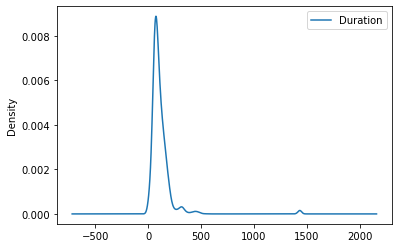

In [150]:
flights[["Duration"]].plot.kde()

In [151]:
(flights["Duration"]<0).sum()

0

In [156]:
(flights["Duration"]>1200).sum()

214

In [155]:
24*60

1440

In [157]:
flights[flights["Duration"]>1200].head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime,ActDayofMonth,Duration
18828,ATL,HSV,1,2150,2149,22,8,152,46,2,1426
42892,SBN,ORD,1,2018,2022,114,59,296,45,2,1425
20151,PHX,LAS,1,625,625,620,618,-5,58,1,1438
20942,MQT,GRB,1,645,630,717,657,32,40,1,1420
21465,ATL,DHN,1,825,823,823,820,-2,57,1,1437


In [158]:
flights[(flights["Origin"]=="ATL") & (flights["Dest"]=="HSV")]

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ActualElapsedTime,ActDayofMonth,Duration
18828,ATL,HSV,1,2150,2149,22,8,152,46,2,1426
21613,ATL,HSV,1,841,842,856,908,15,72,1,12
24328,ATL,HSV,2,841,842,840,856,-1,76,2,16
24432,ATL,HSV,2,946,944,947,951,1,64,2,4
27026,ATL,HSV,3,841,843,836,833,-5,57,3,1437
27140,ATL,HSV,3,946,944,958,955,12,57,3,1437
29500,ATL,HSV,4,841,843,837,909,-4,92,4,32
29598,ATL,HSV,4,946,944,953,957,7,64,4,4
32090,ATL,HSV,5,841,843,932,929,51,57,5,1437
33928,ATL,HSV,6,841,842,836,831,-5,55,6,1435


### 1.5.2 Посмотреть число рейсов по дням

In [107]:
number_of_flights_per_day = [ (flights["ActDayofMonth"]==i).sum() for i in range(1,32,1)]

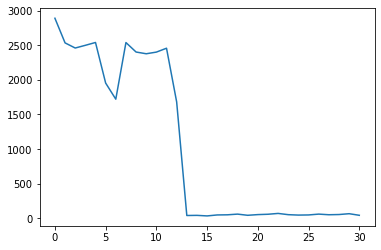

In [108]:
plt.plot(number_of_flights_per_day)

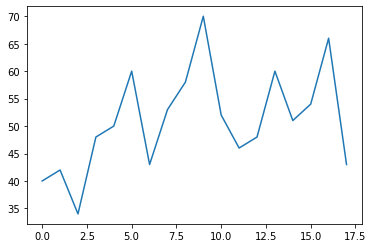

In [111]:
plt.plot(number_of_flights_per_day[13:])

# 2. Моделирование расспространения болезни между аэропортами

In [103]:
544%100

44

In [107]:
int(594/100)

5

In [112]:
187+169

356

In [165]:
airports1 = set(flights["Origin"].unique())
airports2 = set(flights["Dest"].unique())
airports = list(airports1.union(airports2))

In [166]:
print(len(airports1), len(airports2), len(airports))

260 207 266


In [167]:
print(airports[:10])

['TUS', 'ABE', 'STL', 'GCC', 'SWF', 'LAS', 'IAD', 'PSC', 'GRR', 'CDC']


In [169]:
airports.sort()

In [170]:
print(airports[:10])

['ABE', 'ABI', 'ABQ', 'ABY', 'ACT', 'ACV', 'ADQ', 'AEX', 'AGS', 'ALB']


In [171]:
air_dict= {item: 0 for item in airports}

In [172]:
print(air_dict)

{'ABE': 0, 'ABI': 0, 'ABQ': 0, 'ABY': 0, 'ACT': 0, 'ACV': 0, 'ADQ': 0, 'AEX': 0, 'AGS': 0, 'ALB': 0, 'AMA': 0, 'ANC': 0, 'ASE': 0, 'ATL': 0, 'ATW': 0, 'AUS': 0, 'AVL': 0, 'AVP': 0, 'AZO': 0, 'BDL': 0, 'BET': 0, 'BFL': 0, 'BGM': 0, 'BGR': 0, 'BHM': 0, 'BIL': 0, 'BIS': 0, 'BMI': 0, 'BNA': 0, 'BOI': 0, 'BOS': 0, 'BQK': 0, 'BQN': 0, 'BRO': 0, 'BTM': 0, 'BTR': 0, 'BTV': 0, 'BUF': 0, 'BUR': 0, 'BWI': 0, 'BZN': 0, 'CAE': 0, 'CAK': 0, 'CDC': 0, 'CEC': 0, 'CHA': 0, 'CHO': 0, 'CHS': 0, 'CIC': 0, 'CID': 0, 'CLD': 0, 'CLE': 0, 'CLT': 0, 'CMH': 0, 'CMI': 0, 'CMX': 0, 'COD': 0, 'COS': 0, 'CPR': 0, 'CRP': 0, 'CRW': 0, 'CSG': 0, 'CVG': 0, 'CWA': 0, 'DAB': 0, 'DAL': 0, 'DAY': 0, 'DBQ': 0, 'DCA': 0, 'DEN': 0, 'DFW': 0, 'DHN': 0, 'DLH': 0, 'DRO': 0, 'DSM': 0, 'DTW': 0, 'EGE': 0, 'EKO': 0, 'ELP': 0, 'ERI': 0, 'EUG': 0, 'EVV': 0, 'EWN': 0, 'EWR': 0, 'EYW': 0, 'FAI': 0, 'FAR': 0, 'FAT': 0, 'FAY': 0, 'FCA': 0, 'FLG': 0, 'FLL': 0, 'FLO': 0, 'FNT': 0, 'FSD': 0, 'FSM': 0, 'FWA': 0, 'GCC': 0, 'GEG': 0, 'GFK': 0,

In [173]:
import pickle
with open('../data/air_dictionary.pkl', 'wb') as f:
    pickle.dump(air_dict, f)